In [1]:
# %load sobel.py
import cv2
import numpy as np

class SB:
    def __init__(self, img):
        self.img = img
        self.sobelX = None
        self.sobelY = None
        self.sb = None

    # use kernel to filter the input image
    def kernel_filter (self, kernel):
        height, width = self.img.shape
        kernel_height, kernel_width = kernel.shape

        img_pad = np.zeros(((height+2), (width+2)), np.float32)
        img_pad[1:height+1, 1:width+1] = self.img

        window = np.zeros((kernel_height, kernel_width), np.float32)
        value = np.zeros((kernel_height, kernel_width), np.float32)
        img_filter = np.zeros((height, width))

        for row in range(1, height):
            for col in range(1, width):
                window = img_pad[(row - 1): (row + 2), (col - 1): (col + 2)]
                value = window*kernel
                img_filter[row-1, col-1] = int(value.sum())

        return img_filter

    def filter(self):
        filterX = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        filterY = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        filterG = np.array([(1, 2, 1), (2, 4, 2), (1, 2, 1)], np.float32)/16

        self.sobelX = self.kernel_filter(filterX)
        self.sobelY = self.kernel_filter(filterY)

        sb = cv2.magnitude(self.sobelX, self.sobelY)
        #(self.sobelX**2 + self.sobelY**2)**0.5
        self.sb = cv2.GaussianBlur(sb, (5,5), 0)

    def threshold(self):
        th = 100
        img_thr = np.copy(self.sb)
        img_thr[img_thr >= th] = 0
        img_thr[img_thr != 0] = 255

        self.sb = img_thr

    def sobel(self):
        self.filter()
        self.threshold()
        return self.sb

# example
img = cv2.imread('sample2.jpg', 0)
img = cv2.resize(img, (150,200),)
sb = SB(img)

img = sb.sobel()
 
#cv2.imshow('img',img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


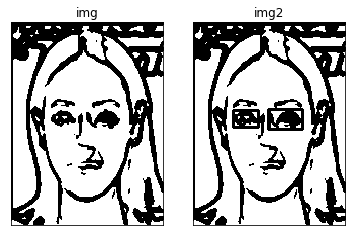

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def eye_region(img):
    height, width = img.shape
    h1, h2, w1, w2 = int(height/3), int(3*height/5), int(width/4), int(3*width/4)
    hist = np.zeros((h2-h1),dtype = np.uint8)

    for i in range(h1, h2):
        hist[i-h1] = (img[i,w1:w2] == 0).sum()
    center_line = hist.argmax()

    search_region = 255 - img[h1:h2, w1:w2]
    left,right = np.zeros(4), np.zeros(4)
    left_min, right_min = 99, 99
    i_left, i_right = 0, 0

    output = cv2.connectedComponentsWithStats(np.uint8(search_region), 8, cv2.CV_32S)
    stats = output[2]
    for i in range(0, stats.shape[0]):
        x_pos = stats[i,0] + int(stats[i,2]/2)
        y_pos = stats[i,1] + int(stats[i,3]/2)
        if stats[i,4] >= 30:
            #component is left eye
            if x_pos < ((w2-w1)/2):
                if abs(y_pos - center_line) < left_min:
                    left_min = abs(y_pos - center_line)
                    i_left = i
            #component is right eye
            if x_pos > ((w2-w1)/2):
                if abs(y_pos - center_line) < right_min:
                    right_min = abs(y_pos - center_line)
                    i_right = i
    left = stats[i_left, 0:4]
    left[0] += w1
    left[1] += h1
    right = stats[i_right, 0:4]
    right[0] += w1
    right[1] += h1

    return center_line+h1, left, right

histo = eye_region(img)
img2 = img.copy()
cv2.rectangle(img2,           
              (histo[1][0], histo[1][1]),                 # upper left corner
              (histo[1][0]+histo[1][2], histo[1][1]+histo[1][3]),        # lower right corner
              (0, 0, 255),                  # red
              2)
cv2.rectangle(img2,           
              (histo[2][0], histo[2][1]),                 # upper left corner
              (histo[2][0]+histo[2][2], histo[2][1]+histo[2][3]),        # lower right corner
              (0, 0, 255),                  # red
              2)

plt.subplot(121), plt.imshow(img, cmap="gray")
plt.title("img"),plt.xticks([]),plt.yticks([])
plt.subplot(122), plt.imshow(img2, cmap="gray")
plt.title("img2"),plt.xticks([]),plt.yticks([])
plt.show()